In [1]:
import numpy as np
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt

In [2]:
num_pts = 1000
r = 3.5

In [3]:
X = np.empty([num_pts, 2])
x,y = np.random.uniform(), np.random.uniform()
for i in range(num_pts):
    X[i,:] = [x,y]
    x = (X[i,0] + r*X[i,1]*(1-X[i,1])) %1
    y = (X[i,1] + r*x*(1-x)) %1

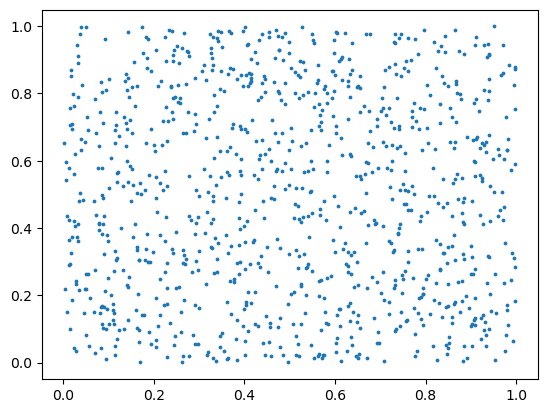

In [4]:
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

In [5]:
acX = gd.AlphaComplex(points=X).create_simplex_tree()
dgmX = acX.persistence()

usetex mode requires TeX.


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

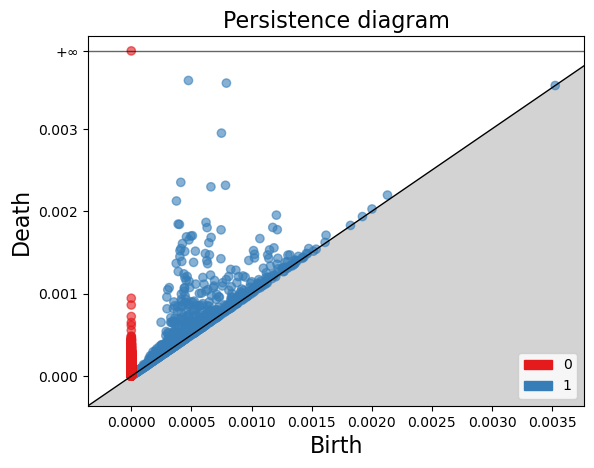

In [6]:
gd.plot_persistence_diagram(dgmX)

### Persistent Landscape

In [7]:
LS = gd.representations.Landscape(resolution=1000)
L = LS.fit_transform([acX.persistence_intervals_in_dimension(1)])

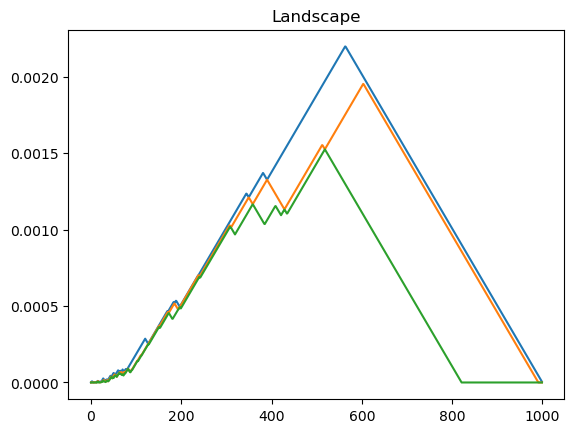

In [8]:
plt.plot(L[0][:1000])
plt.plot(L[0][1000:2000])
plt.plot(L[0][2000:3000])
plt.title('Landscape')
plt.show()

In [9]:
SH = gd.representations.Silhouette(resolution=1000, weight = lambda x: np.power(x[1]-x[0],1))
sh = SH.fit_transform([acX.persistence_intervals_in_dimension(1)])

Text(0.5, 1.0, 'Silhouette')

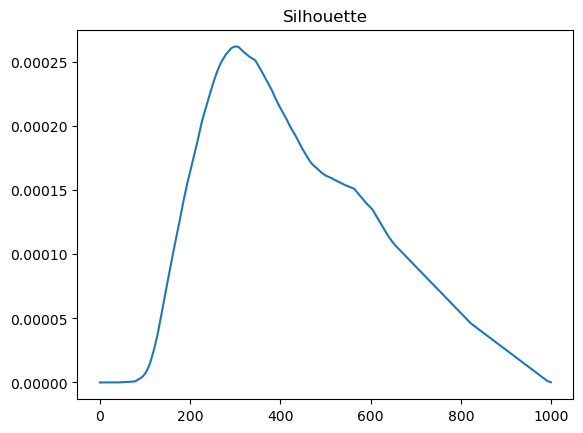

In [10]:
plt.plot(sh[0])
plt.title('Silhouette')

### Persistence Image

In [11]:
PI = gd.representations.PersistenceImage(bandwidth = 1e-4, weight = lambda x: x[1]**2, im_range = [0,.004,0,.004], resolution=[100,100])
pi = PI.fit_transform([acX.persistence_intervals_in_dimension(1)])

Text(0.5, 1.0, 'Persistence Image')

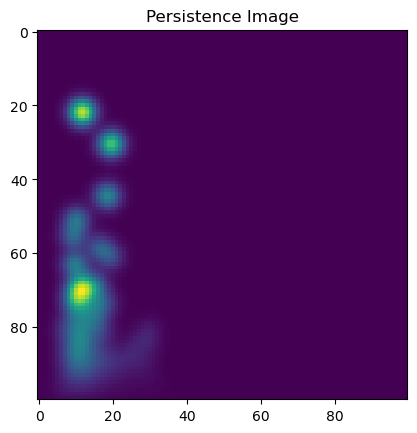

In [12]:
plt.imshow(np.flip(np.reshape(pi[0],[100,100]),0))
plt.title('Persistence Image')

### Kernel

In [13]:
r = 4.1
Y =np.empty([num_pts,2])
x,y = np.random.uniform(), np.random.uniform()
for i in range(num_pts):
    Y[i,:] = [x,y]
    x = (Y[i,0] + r*Y[i,1]*(1-Y[i,1])) %1
    y = (Y[i,1] + r*x*(1-x)) %1

In [14]:
acY = gd.AlphaComplex(points=Y).create_simplex_tree()
dgmY = acY.persistence()

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

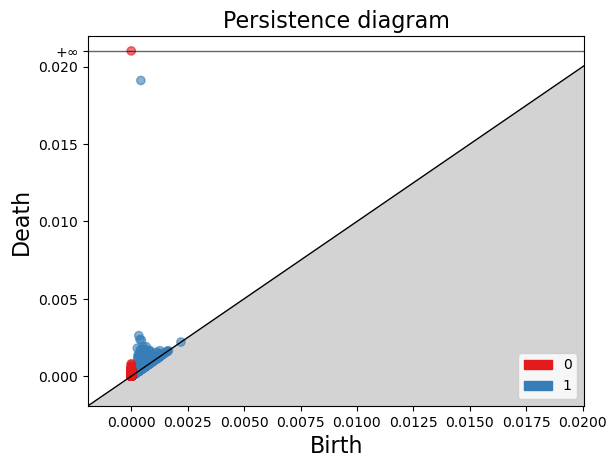

In [15]:
gd.plot_persistence_diagram(dgmY)

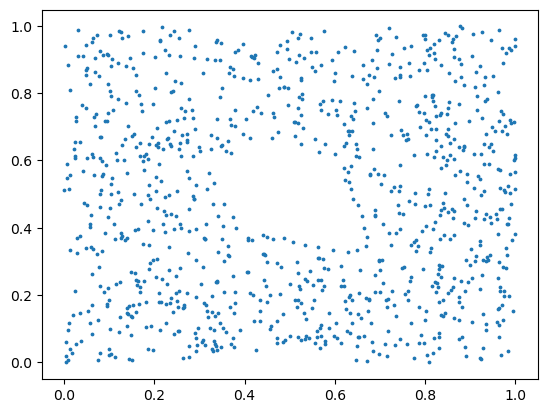

In [16]:
plt.scatter(Y[:,0], Y[:,1], s=3)
plt.show()

In [17]:
PWG = gd.representations.PersistenceWeightedGaussianKernel(bandwidth=0.01, kernel_approx=None, \
                                                           weight = lambda x: np.arctan(np.power(x[1],1)))
PWG.fit([acX.persistence_intervals_in_dimension(1)])
pwg = PWG.transform([acY.persistence_intervals_in_dimension(1)])
print('PWG kernel is ' + str(pwg[0][0]))

PSS = gd.representations.PersistenceScaleSpaceKernel(bandwidth=1.)
PSS.fit([acX.persistence_intervals_in_dimension(1)])
pss = PSS.transform([acY.persistence_intervals_in_dimension(1)])
print('PSS kernel is ' +str(pss[0][0]))

PF = gd.representations.PersistenceFisherKernel(bandwidth_fisher=.001, bandwidth = .001, kernel_approx=None)
PF.fit([acX.persistence_intervals_in_dimension(1)])
pf = PF.transform([acY.persistence_intervals_in_dimension(1)])
print('PF kernel is '+str(pf[0][0]))

SW = gd.representations.SlicedWassersteinKernel(bandwidth=.1, num_directions=100)
SW.fit([acX.persistence_intervals_in_dimension(1)])
sw = SW.transform([acY.persistence_intervals_in_dimension(1)])
print("SW kernel is " + str(sw[0][0]))

BD = gd.representations.BottleneckDistance(epsilon=.001)
BD.fit([acX.persistence_intervals_in_dimension(1)])
bd = BD.transform([acY.persistence_intervals_in_dimension(1)])
print("Bottleneck distance is " + str(bd[0][0]))

WD = gd.representations.WassersteinDistance(internal_p=2, order=2)
WD.fit([acX.persistence_intervals_in_dimension(1)])
wd = WD.transform([acY.persistence_intervals_in_dimension(1)])
print("Wasserstein distance is " + str(wd[0][0]))

PWG kernel is 12.502917543315728
PSS kernel is 0.005126353254937044
PF kernel is 0.48907883971409893
SW kernel is 0.8343343029601862
Bottleneck distance is 0.008690032979282121
Wasserstein distance is 0.013437171378630663


### Cross-validation

In [18]:
num_diag_per_class = 10

dgms, labs =[], []

for idx, radius in enumerate([2.5,3.5, 4., 4.1, 4.3]):
    for _ in range(num_diag_per_class):
        labs.append(idx)
        X = np.empty([num_pts,2])
        x, y = np.random.uniform(), np.random.uniform()

        for i in range(num_pts):
            X[i,:] = [x, y]
            x = (X[i,0] + radius * X[i,1] * (1-X[i,1])) % 1.
            y = (X[i,1] + radius * x * (1-x)) % 1.
        ac = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=1e12)
        dgm = ac.persistence()
        dgms.append(ac.persistence_intervals_in_dimension(1))

In [19]:
test_size = 0.2
perm = np.random.permutation(len(labs))
limit = int(test_size*len(labs))
test_sub, train_sub = perm[:limit], perm[limit:]
train_labs = np.array(labs)[train_sub]
test_labs = np.array(labs)[test_sub]
train_dgms = [dgms[i] for i in train_sub]
test_dgms = [dgms[i] for i in test_sub]

In [20]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

# Definition of pipeline
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", SVC())])

# Parameters of pipeline. This is the place where you specify the methods you want to use to handle diagrams
param =    [{"Scaler__use":         [False],
             "TDA":                 [gd.representations.SlicedWassersteinKernel()], 
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]},
            
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.PersistenceWeightedGaussianKernel()], 
             "TDA__bandwidth":      [0.1, 0.01],
             "TDA__weight":         [lambda x: np.arctan(x[1]-x[0])], 
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.PersistenceImage()], 
             "TDA__resolution":     [ [5,5], [6,6] ],
             "TDA__bandwidth":      [0.01, 0.1, 1.0, 10.0],
             "Estimator":           [SVC()]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.Landscape()], 
             "TDA__resolution":     [100],
             "Estimator":           [RandomForestClassifier()]},
           
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [KNeighborsClassifier(metric="precomputed")]}
           ]

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
model = GridSearchCV(pipe, param, cv=3)

In [23]:
model = model.fit(train_dgms, train_labs)

C:\Users\Seungyun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Seungyun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

In [24]:
print(model.best_params_)

{'Estimator': RandomForestClassifier(), 'Scaler__use': True, 'TDA': Landscape(), 'TDA__resolution': 100}


In [25]:
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 1.0
Test accuracy  = 0.6
